## Master Notebook

The goal of this notebook is to use our training data set to fit a multiple linear regression model to predict house prices in King County, Washington.

## Steps

* Import Training Data
* Check Assumptions of Linear Regression
* Create New Metrics
* Iterate Through Regression Models (Choose Best in Terms of R-Squared)
* Let The User Input Hypothetical Home Data to Predict the Price of Their Home

## Import Training Data

In [1]:
#Pull in Data
import pandas as pd
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('Train_Table.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,id,bedrooms,bathrooms,sqft_living,log_lot,sqft_lot,floors,waterfront,condition,grade,zipcode,lat,long,yr_of_last_update,season_sold,below_ground_ratio,price_100k,long_lat,district,is_seattle
0,7504400290,5,2.50,3470,9.392912,12003,2.0,0.0,3,8,98074,47.6240,-122.048,1978,Spring,0.000000,5.990,"(-122.04799999999999, 47.623999999999995)",Lake Washington,0.0
1,6403500570,5,2.75,2990,8.911934,7420,2.0,0.0,3,8,98059,47.4944,-122.162,1996,Summer,0.000000,4.985,"(-122.162, 47.4944)",Renton,0.0
2,7934000145,4,2.75,2900,8.764053,6400,2.0,0.0,3,7,98136,47.5563,-122.393,1970,Winter,0.421569,4.500,"(-122.39299999999999, 47.5563)",Seattle,1.0
3,203100625,3,2.50,2620,9.979847,21587,2.0,0.0,3,7,98053,47.6384,-121.959,1992,Spring,0.000000,6.720,"(-121.959, 47.6384)",Snoqualmie Valley,0.0
4,2211700160,3,1.50,1770,9.753130,17208,1.0,0.0,3,8,98006,47.5659,-122.117,1959,Spring,0.525862,4.500,"(-122.117, 47.5659)",Issaquah,0.0


In [2]:
df.shape

(17094, 20)

## Check Linearity Assumption

In [3]:
def linearity_test(df):
    y = df['price_100k']
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15))
    for n in range(len(df.columns) - 1):
        row = (n-1)//3
        col = n%3-1
        ax = axes[row][col]
        column = df.columns[n]
        x = df[column]
        ax.scatter(x,y)
        ax.set_title(str(column) + ' vs Price')

In [4]:
#Create df with only variables we could use in regression.  Create log_lot variable
reg_df = df.drop(['zipcode', 'lat', 'long', 'id', 'long_lat', 'sqft_lot'], axis=1)

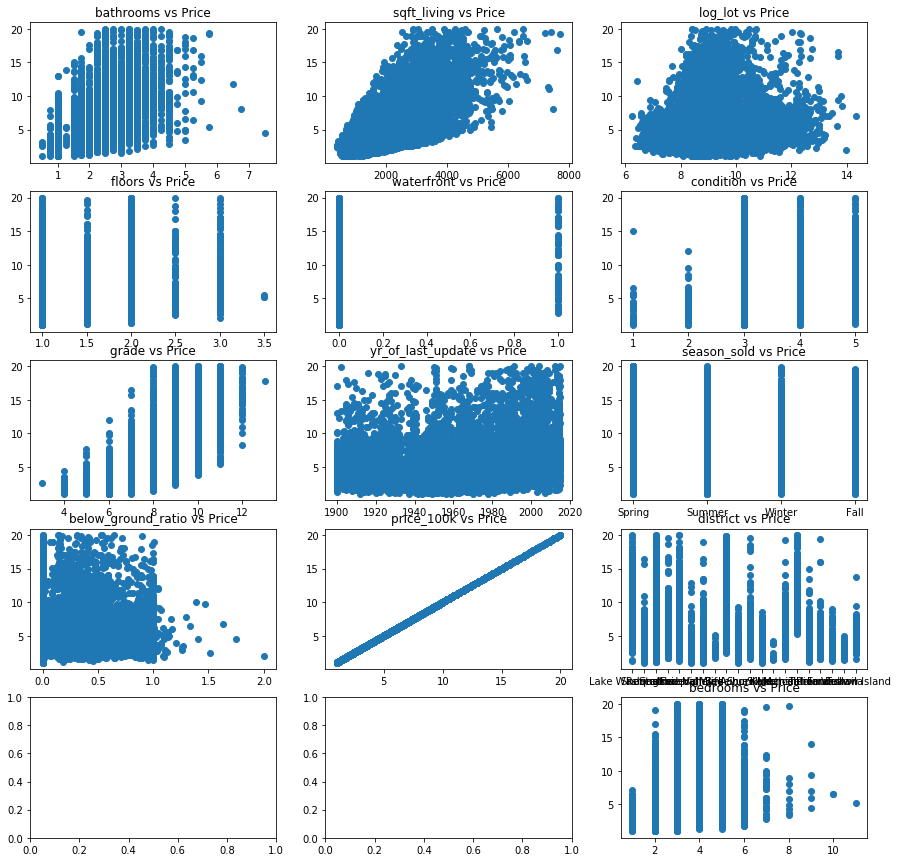

In [5]:
linearity_test(reg_df)

Grade, Bathrooms, and Sqft_living seem to have linear relationships with price.  Other variables have less linear relationships, so adjustments may have to be made

## Plot Histograms

In [6]:
def plot_histograms(df):
    fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15,15))
    for n in range(len(df.columns) - 1):
        row = (n-1)//3
        col = n%3-1
        ax = axes[row][col]
        column = df.columns[n]
        x = df[column]
        ax.hist(x)
        ax.set_title(str(column))
        

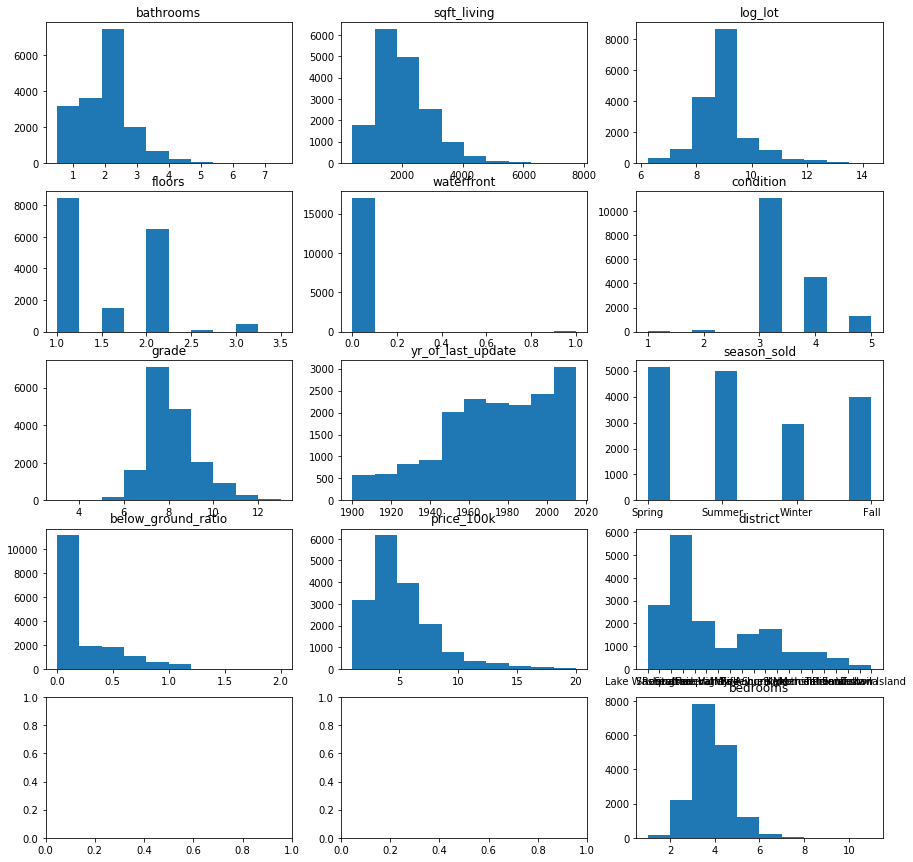

In [7]:
plot_histograms(reg_df)

Normally distributed variables are not a requirement of Linear Regression, but this helps us understand our data better.

## Check For Multicollinearity

In [8]:
def check_multicollinearity(df, independent_var_name, cutoff):
    copy_df = df.drop(independent_var_name, axis=1)
    # copy_df = reg_df

    # save absolute value of correlation matrix as a data frame
    # converts all values to absolute value
    # stacks the row:column pairs into a multindex
    # reset the index to set the multindex to seperate columns
    # sort values. 0 is the column automatically generated by the stacking

    pair_df=copy_df.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    # zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    pair_df['pairs'] = list(zip(pair_df.level_0, pair_df.level_1))

    # set index to pairs
    pair_df.set_index(['pairs'], inplace = True)

    #drop level columns
    pair_df.drop(columns=['level_1', 'level_0'], inplace = True)

    # rename correlation column
    pair_df.columns = ['correlation_coefficient']

    # drop duplicates. 
    pair_df.drop_duplicates(inplace=True)
    return pair_df[(pair_df.correlation_coefficient>cutoff) & (pair_df.correlation_coefficient <1)]

In [9]:
check_multicollinearity(reg_df, 'price_100k', 0.6)

,correlation_coefficient
pairs,
"(grade, sqft_living)",0.750909
"(bathrooms, sqft_living)",0.742246
"(grade, bathrooms)",0.650483


Grade, sqft_living, and bathrooms are correlated with eachother, so interpreting the coefficients of these variables will be inaccurate.

## Create New Metrics

**Create top_5_district**

This code converts district names into a single binary column.  This new column shows a '1' if the house is in one of the top 5 King County public school districts, and a '0' otherwise.  This metric is more interpretable than having 20 different categorical variables for district (one for each district).

In [11]:
# https://backgroundchecks.org/top-school-districts-in-washington-2018.html
# Rankings based on student performance (math and reading test scores), dropout rates, school funding, and area poverty rates
top_5_str = 'Mercer Island|Lake Washington|Snoqualmie Valley|Bellevue|Issaquah'
reg_df.loc[reg_df['district'].str.contains(top_5_str),'top_5_district'] = 1
reg_df['top_5_district'].fillna(0, inplace=True)
reg_df.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,season_sold,below_ground_ratio,price_100k,district,is_seattle,top_5_district
0,5,2.50,3470,9.392912,2.0,0.0,3,8,1978,Spring,0.000000,5.990,Lake Washington,0.0,1.0
1,5,2.75,2990,8.911934,2.0,0.0,3,8,1996,Summer,0.000000,4.985,Renton,0.0,0.0
2,4,2.75,2900,8.764053,2.0,0.0,3,7,1970,Winter,0.421569,4.500,Seattle,1.0,0.0
3,3,2.50,2620,9.979847,2.0,0.0,3,7,1992,Spring,0.000000,6.720,Snoqualmie Valley,0.0,1.0
4,3,1.50,1770,9.753130,1.0,0.0,3,8,1959,Spring,0.525862,4.500,Issaquah,0.0,1.0


In [12]:
#Drop old district variable
reg_df.drop(['district'], axis=1, inplace=True)

**Get Season Dummy Variables**

This shows the effect that season has on the price of a home, relative to the price of homes sold in the Fall.

In [13]:
#Dummy var for season_sold, with Summer as the reference variable
seasons = pd.get_dummies(reg_df['season_sold'], drop_first=True)
reg_df = pd.concat([reg_df, seasons], axis=1)
# reg_df.drop(['Summer'], axis=1, inplace=True)

In [14]:
reg_df = reg_df.drop(['season_sold'], axis=1)
reg_df.head()

,bedrooms,bathrooms,sqft_living,log_lot,floors,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter
0,5,2.50,3470,9.392912,2.0,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0
1,5,2.75,2990,8.911934,2.0,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0
2,4,2.75,2900,8.764053,2.0,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1
3,3,2.50,2620,9.979847,2.0,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0
4,3,1.50,1770,9.753130,1.0,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0


## Iterate Through Regression Models

For the sake of brevity, early models are not included here.  Early models treated Floors, Grade, and Condition as continuous variables, but R-Squared was improved by treating them as categorical variables.

In [15]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

**Check Residual Homoscedasticity**

In [16]:
# Check Homoskedasticity
def gq_test(data, model):
    
    #Graph heteroskedasticity
    pred_val = model.fittedvalues.copy()
#     true_val = data['price_100k'].values.copy()
    residual = model.resid
    
    fig, ax = plt.subplots()
    graph = ax.scatter(pred_val, residual)
    
    # Run Goldfeld Quandt test
    name = ['F statistic', 'p-value']
    test = sms.het_goldfeldquandt(model.resid, model.model.exog)
    return list(zip(name, test))


## Regression v1

**Turn Continuous Variables into Categorical Variables**

In [17]:
#Floors
reg_df2 = reg_df
floors = pd.get_dummies(reg_df2['floors'], prefix='floors', drop_first=True)
reg_df2 = pd.concat([reg_df2, floors], axis=1)
reg_df2.drop('floors', axis=1, inplace=True)

#Rename floors so no decimal in column name
reg_df2.rename(columns={'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter,floors_1h,floors_2,floors_2h,floors_3,floors_3h
0,5,2.50,3470,9.392912,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0,0,1,0,0,0
1,5,2.75,2990,8.911934,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0,0,1,0,0,0
2,4,2.75,2900,8.764053,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1,0,1,0,0,0
3,3,2.50,2620,9.979847,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0,0,1,0,0,0
4,3,1.50,1770,9.753130,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0,0,0,0,0,0


In [18]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(reg_df2['grade'], prefix='grade', drop_first=True)
reg_df2 = pd.concat([reg_df2, grade], axis=1)
reg_df2.drop('grade', axis=1, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,5,2.50,3470,9.392912,0.0,3,1978,0.000000,5.990,0.0,...,0,0,0,0,1,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,1996,0.000000,4.985,0.0,...,0,0,0,0,1,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,1970,0.421569,4.500,1.0,...,0,0,0,1,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,1992,0.000000,6.720,0.0,...,0,0,0,1,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,1959,0.525862,4.500,0.0,...,0,0,0,0,1,0,0,0,0,0


In [19]:
#Condition 
condition = pd.get_dummies(reg_df2['condition'], prefix='cond', drop_first=True)
reg_df2 = pd.concat([reg_df2, condition], axis=1)
reg_df2.drop('condition', axis=1, inplace=True)
reg_df2.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_2,cond_3,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,1,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,1,0,0


In [22]:
outcome = 'price_100k'
predictors = reg_df2.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:44:27   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1604      2.044     13.289      0.000      23.154      31.166
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1h             -0.0031      0.047     -0.067      0.947      -0.095       0.089
floors_2              -0.2617      0.039     -6.637      0.000      -0.339      -0.184
floors_2h              0.2624      0.150      1.750      0.080      -0.031       0.556
floors_3              -0.0305      0.087     -0.352      0.725      -0.201       0.140
floors_3h             -0.1524      0.882     -0.173      0.863      -1.881       1.576
grade_4               -0.5704      1.565     -0.365      0.715      -3.637       2.497
grade_5               -0.6333      1.529     -0.414      0.679      -3.630       2.364
grade_6               -0.5888      1.526     -0.386      0.700      -3.579       2.401
grade_7                0.0190      1.526      0.012      0.990      -2.971       3.009
grade_8                0.8375      1.526      0.549      0.583      -2.154       3.829
grade_9                2.0868      1.527      1.367      0.172      -0.906       5.079
grade_10               3.3062      1.528      2.164      0.030       0.312       6.301
grade_11               4.6901      1.531      3.064      0.002       1.690       7.690
grade_12               7.0178      1.544      4.544      0.000       3.991      10.045
grade_13               9.2811      2.159      4.299      0.000       5.049      13.513
cond_2                -0.0801      0.346     -0.231      0.817      -0.759       0.599
cond_3                 0.2067      0.321      0.645      0.519      -0.422       0.835
cond_4                 0.4852      0.321      1.513      0.130      -0.143       1.114
cond_5                 0.8998      0.323      2.790      0.005       0.268       1.532
======================================

**Check Normality of Residuals**

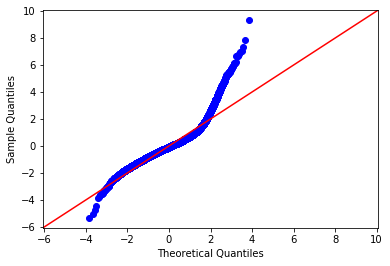

In [23]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

This indicates serious issues with normality.  The assumption of normal residuals is not met.

**Check Heteroscedasticity**

[('F statistic', 1.036604823912329), ('p-value', 0.04858643950891584)]

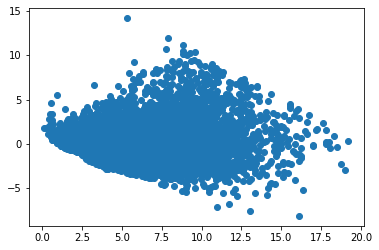

In [24]:
gq_test(reg_df2, model)

This is not a worst-case scenario, but a visual inspection shows that there is some heteroscedasticity.

## Regression v2

Here the reference variables in the regression's categorical variables were adjusted to more accurately reflect the 'average' house.

In [25]:
#Floors
reg_df3 = reg_df
floors = pd.get_dummies(reg_df3['floors'], prefix='floors')
reg_df3 = pd.concat([reg_df3, floors], axis=1)
reg_df3.drop('floors', axis=1, inplace=True)

#Drop floor 2 to make it ref var
reg_df3.drop('floors_2.0', axis=1, inplace=True)

#Rename floors so no decimal in column name
reg_df3.rename(columns={'floors_1.0':'floors_1', 'floors_1.5':'floors_1h','floors_2.0':'floors_2','floors_2.5':'floors_2h','floors_3.0':'floors_3','floors_3.5':'floors_3h'}, inplace=True)

reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,grade,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,Spring,Summer,Winter,floors_1,floors_1h,floors_2h,floors_3,floors_3h
0,5,2.50,3470,9.392912,0.0,3,8,1978,0.000000,5.990,0.0,1.0,1,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,8,1996,0.000000,4.985,0.0,0.0,0,1,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,7,1970,0.421569,4.500,1.0,0.0,0,0,1,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,7,1992,0.000000,6.720,0.0,1.0,1,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,8,1959,0.525862,4.500,0.0,1.0,1,0,0,1,0,0,0,0


In [26]:
#Grade - Data in master table ranges from 3-13
grade = pd.get_dummies(reg_df3['grade'], prefix='grade')
reg_df3 = pd.concat([reg_df3, grade], axis=1)

#Drop Grade 7 (average grade) to make ref var
reg_df3.drop('grade_7', axis=1, inplace=True)

reg_df3.drop('grade', axis=1, inplace=True)
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,condition,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,...,grade_3,grade_4,grade_5,grade_6,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,5,2.50,3470,9.392912,0.0,3,1978,0.000000,5.990,0.0,...,0,0,0,0,1,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,3,1996,0.000000,4.985,0.0,...,0,0,0,0,1,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,3,1970,0.421569,4.500,1.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,3,1992,0.000000,6.720,0.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,3,1959,0.525862,4.500,0.0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
#Condition 
condition = pd.get_dummies(reg_df3['condition'], prefix='cond')
reg_df3 = pd.concat([reg_df3, condition], axis=1)

#Drop Condition 3 (average cond) to make ref var
reg_df3.drop('cond_3', axis=1, inplace=True)

reg_df3.drop('condition', axis=1, inplace=True)
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0


In [28]:
outcome = 'price_100k'
predictors = reg_df3.drop('price_100k', axis=1)
pred_sum = '+'.join(predictors.columns)
formula = outcome + '~' + pred_sum
model = ols(formula=formula, data=reg_df3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:44:36   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             27.1244      1.362     19.916      0.000      24.455      29.794
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1               0.2617      0.039      6.637      0.000       0.184       0.339
floors_1h              0.2586      0.054      4.822      0.000       0.153       0.364
floors_2h              0.5242      0.147      3.575      0.000       0.237       0.812
floors_3               0.2312      0.078      2.966      0.003       0.078       0.384
floors_3h              0.1093      0.881      0.124      0.901      -1.617       1.836
grade_3               -0.0190      1.526     -0.012      0.990      -3.009       2.971
grade_4               -0.5894      0.352     -1.673      0.094      -1.280       0.101
grade_5               -0.6524      0.115     -5.693      0.000      -0.877      -0.428
grade_6               -0.6079      0.045    -13.593      0.000      -0.696      -0.520
grade_8                0.8185      0.032     25.328      0.000       0.755       0.882
grade_9                2.0677      0.049     41.935      0.000       1.971       2.164
grade_10               3.2872      0.071     46.314      0.000       3.148       3.426
grade_11               4.6711      0.117     40.093      0.000       4.443       4.899
grade_12               6.9987      0.235     29.725      0.000       6.537       7.460
grade_13               9.2620      1.527      6.067      0.000       6.270      12.254
cond_1                -0.2067      0.321     -0.645      0.519      -0.835       0.422
cond_2                -0.2868      0.138     -2.084      0.037      -0.557      -0.017
cond_4                 0.2784      0.030      9.397      0.000       0.220       0.337
cond_5                 0.6931      0.048     14.566      0.000       0.600       0.786
======================================

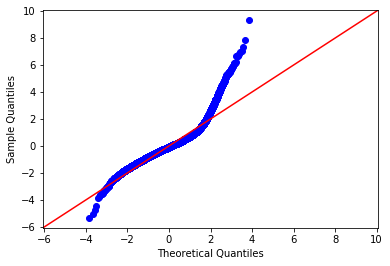

In [29]:
#Normality check for residuals with QQ plot
resid1 = model.resid
fig = sm.graphics.qqplot(resid1, dist=stats.norm, line='45', fit=True)

[('F statistic', 1.0366048239123289), ('p-value', 0.04858643950896008)]

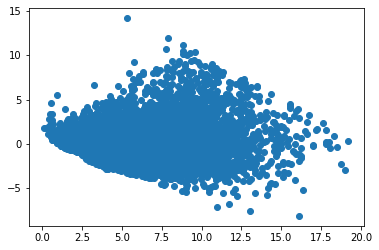

In [30]:
gq_test(reg_df3, model)

## Make Predictions

This is the same model as above, but done using a different method.  This allows us to make predictions with confidence intervals at the end.

In [31]:
y = reg_df3['price_100k']
independent_variables = list(predictors.columns)
X = reg_df3[independent_variables]
display(X.head(3), y.head(3))

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,is_seattle,top_5_district,Spring,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,0.0,1.0,1,...,1,0,0,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,0.0,0.0,0,...,1,0,0,0,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0


0    5.990
1    4.985
2    4.500
Name: price_100k, dtype: float64

In [32]:
import statsmodels.api as sm

Xconst = sm.add_constant(X)

model = sm.OLS(y, Xconst, hasconst= True)

fitted_model = model.fit()

fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_100k   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     1433.
Date:                Thu, 09 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:44:40   Log-Likelihood:                -31441.
No. Observations:               17094   AIC:                         6.295e+04
Df Residuals:                   17062   BIC:                         6.319e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 27.1244      1.362     19.916      0.000      24.455      29.794
bedrooms              -0.1211      0.017     -6.992      0.000      -0.155      -0.087
bathrooms              0.2793      0.028      9.859      0.000       0.224       0.335
sqft_living            0.0014    3.1e-05     43.849      0.000       0.001       0.001
log_lot                0.0482      0.017      2.754      0.006       0.014       0.082
waterfront             4.8166      0.169     28.543      0.000       4.486       5.147
yr_of_last_update     -0.0139      0.001    -20.671      0.000      -0.015      -0.013
below_ground_ratio    -0.3800      0.053     -7.231      0.000      -0.483      -0.277
is_seattle             2.1047      0.037     57.569      0.000       2.033       2.176
top_5_district         1.8094      0.030     59.695      0.000       1.750       1.869
Spring                 0.2767      0.032      8.607      0.000       0.214       0.340
Summer                 0.0262      0.032      0.810      0.418      -0.037       0.090
Winter                 0.0703      0.037      1.895      0.058      -0.002       0.143
floors_1               0.2617      0.039      6.637      0.000       0.184       0.339
floors_1h              0.2586      0.054      4.822      0.000       0.153       0.364
floors_2h              0.5242      0.147      3.575      0.000       0.237       0.812
floors_3               0.2312      0.078      2.966      0.003       0.078       0.384
floors_3h              0.1093      0.881      0.124      0.901      -1.617       1.836
grade_3               -0.0190      1.526     -0.012      0.990      -3.009       2.971
grade_4               -0.5894      0.352     -1.673      0.094      -1.280       0.101
grade_5               -0.6524      0.115     -5.693      0.000      -0.877      -0.428
grade_6               -0.6079      0.045    -13.593      0.000      -0.696      -0.520
grade_8                0.8185      0.032     25.328      0.000       0.755       0.882
grade_9                2.0677      0.049     41.935      0.000       1.971       2.164
grade_10               3.2872      0.071     46.314      0.000       3.148       3.426
grade_11               4.6711      0.117     40.093      0.000       4.443       4.899
grade_12               6.9987      0.235     29.725      0.000       6.537       7.460
grade_13               9.2620      1.527      6.067      0.000       6.270      12.254
cond_1                -0.2067      0.321     -0.645      0.519      -0.835       0.422
cond_2                -0.2868      0.138     -2.084      0.037      -0.557      -0.017
cond_4                 0.2784      0.030      9.397      0.000       0.220       0.337
cond_5                 0.6931      0.048     14.566      0.000       0.600       0.786
======================================

In [33]:
#Find predictions
y_predict = fitted_model.predict(Xconst)

In [34]:
reg_df3.head()

,bedrooms,bathrooms,sqft_living,log_lot,waterfront,yr_of_last_update,below_ground_ratio,price_100k,is_seattle,top_5_district,...,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,cond_1,cond_2,cond_4,cond_5
0,5,2.50,3470,9.392912,0.0,1978,0.000000,5.990,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
1,5,2.75,2990,8.911934,0.0,1996,0.000000,4.985,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
2,4,2.75,2900,8.764053,0.0,1970,0.421569,4.500,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,3,2.50,2620,9.979847,0.0,1992,0.000000,6.720,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,3,1.50,1770,9.753130,0.0,1959,0.525862,4.500,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0


In [35]:
#Ex: 5 provided columns are Grade, Condition, Sqft_living, Waterfront, Bedroom, Bathroom
#Know date, so if spring, factor that in
#Know location, so factor in school district and is_seattle

In [36]:
array_columns = independent_variables
array_columns.insert(0, 1)
array_columns

[1,
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'log_lot',
 'waterfront',
 'yr_of_last_update',
 'below_ground_ratio',
 'is_seattle',
 'top_5_district',
 'Spring',
 'Summer',
 'Winter',
 'floors_1',
 'floors_1h',
 'floors_2h',
 'floors_3',
 'floors_3h',
 'grade_3',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_8',
 'grade_9',
 'grade_10',
 'grade_11',
 'grade_12',
 'grade_13',
 'cond_1',
 'cond_2',
 'cond_4',
 'cond_5']

Below we create a list of empty values.  At the end the user will fill in their data.  Data not filled in is calculated as the median value.

In [37]:
#List of Empty Values
empty_values = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
len(empty_values)

32

In [38]:
prediction_values = np.array([array_columns, empty_values])
prediction_values

array([['1', 'bedrooms', 'bathrooms', 'sqft_living', 'log_lot',
        'waterfront', 'yr_of_last_update', 'below_ground_ratio',
        'is_seattle', 'top_5_district', 'Spring', 'Summer', 'Winter',
        'floors_1', 'floors_1h', 'floors_2h', 'floors_3', 'floors_3h',
        'grade_3', 'grade_4', 'grade_5', 'grade_6', 'grade_8', 'grade_9',
        'grade_10', 'grade_11', 'grade_12', 'grade_13', 'cond_1',
        'cond_2', 'cond_4', 'cond_5'],
       ['1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0']], dtype='<U21')

In [39]:
#Function to find index based on column name
def find_index(col_name, array_2d):
    x = 0
    for i in array_2d[0]:
        if i == col_name:
            return x
        else:
            x += 1

## Create User Input Function

In [40]:
def get_home_stats(df, col_names, fit_model, seattle=0, top_dist=0, spring=0):
    #Known variables given as inputs
        
    empty_values = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    prediction_values = np.array([col_names, empty_values])
    
    #Floors
    floor_num = input("Number of floors ('1' for one floor, '1h' for 1.5 floors): ")
    floor_str = 'floors_' + str(floor_num)
    prediction_values[1][find_index(floor_str, prediction_values)] = 1
    
    #Bedrooms
    bed_num = input("Number of bedrooms (whole number): ")
    prediction_values[1][find_index('bedrooms', prediction_values)] = bed_num
    
    #Bathrooms
    bath_num = input("Number of bathrooms: ")
    prediction_values[1][find_index('bathrooms', prediction_values)] = bath_num
    
    #Waterfront
    wf = input("Is your house on the waterfront? (1 for yes, 0 for no): ")
    prediction_values[1][find_index('waterfront', prediction_values)] = wf
    
    #Square feet
    sqft = input("Total square feet: ")
    prediction_values[1][find_index('sqft_living', prediction_values)] = sqft
    
    #Grade
    grade_num = input("House grade(whole number 3-13): ")
    grade_str = 'grade_' + str(grade_num)
    prediction_values[1][find_index(grade_str, prediction_values)] = 1
    
    #Condition
    cond_num = input("House condition (whole number 1-5): ")
    cond_str = 'cond_' + str(cond_num)
    prediction_values[1][find_index(cond_str, prediction_values)] = 1
    
    
    #Set values for vars known from location/date
    prediction_values[1][find_index('is_seattle', prediction_values)] = seattle
    prediction_values[1][find_index('top_5_district', prediction_values)] = top_dist
    prediction_values[1][find_index('Spring', prediction_values)] = spring
    
    # Set values for unknown variables as median - log_lot, below_ground_ratio, yr_of_last_update
    prediction_values[1][find_index('log_lot', prediction_values)] = df['log_lot'].median()
    prediction_values[1][find_index('below_ground_ratio', prediction_values)] = df['below_ground_ratio'].median()
#     prediction_values[1][find_index('yr_of_last_update', prediction_values)] = df['yr_of_last_update'].median()
    prediction_values[1][find_index('yr_of_last_update', prediction_values)] = 1905
    
    
    #Get values only in array
    prediction_input = prediction_values[1].astype(float)
    
    #Calculate intervals
    intervals = fit_model.get_prediction(prediction_input)
    bounds = intervals.summary_frame(alpha=0.05)
    
    #Format and print
    # Shows the bounds for true average value of a home of this type
    lower_bound = bounds['mean_ci_lower'][0] * 100000
    upper_bound = bounds['mean_ci_upper'][0] * 100000
    print('Your house is worth between ' + "${:,.0f}".format(lower_bound) + ' and ' "${:,.0f}".format(upper_bound) + '!')

## Calculate Predicted Price for Our Home

Call this function and input different parameters to see the home's predicted value.  Our product assumes we know the user's location and the date, so is_seattle, is_top_5_dist, and Spring are treated as known variables.

In [ ]:
get_home_stats(reg_df3, array_columns, fitted_model, seattle=0, top_dist=0, spring=0)

## Next Steps

With additional time we would:
* Fix normality issues in model.
* Fix heteroskedasticity issues in model.
* Fix multicollinearity issues in model
* Test effectiveness of model using test data.